['C' 'Dmin7' 'Dm' 'Emin7' 'Em' 'F' 'Dm' 'G' 'Emin7' 'Cmaj7' 'C' 'Cmaj7'
 'C7' 'C' 'Fmaj7' 'F' 'Am' 'C' 'Cmaj7' 'Am' 'C' 'G' 'G7' 'Em' 'Emin7' 'Dm'
 'G' 'Dmin7' 'Cm' 'C' 'Cm' 'C' 'Cmaj7']
[ 0.    0.93  1.02  1.95  2.04  2.97  3.9   3.99  5.48  5.57  5.67  5.76
  6.97  7.71  7.89  7.99  9.57  9.66 10.5  10.96 11.42 11.98 12.45 13.
 13.47 13.56 13.65 13.93 14.02 15.14 15.33 15.42 15.79]


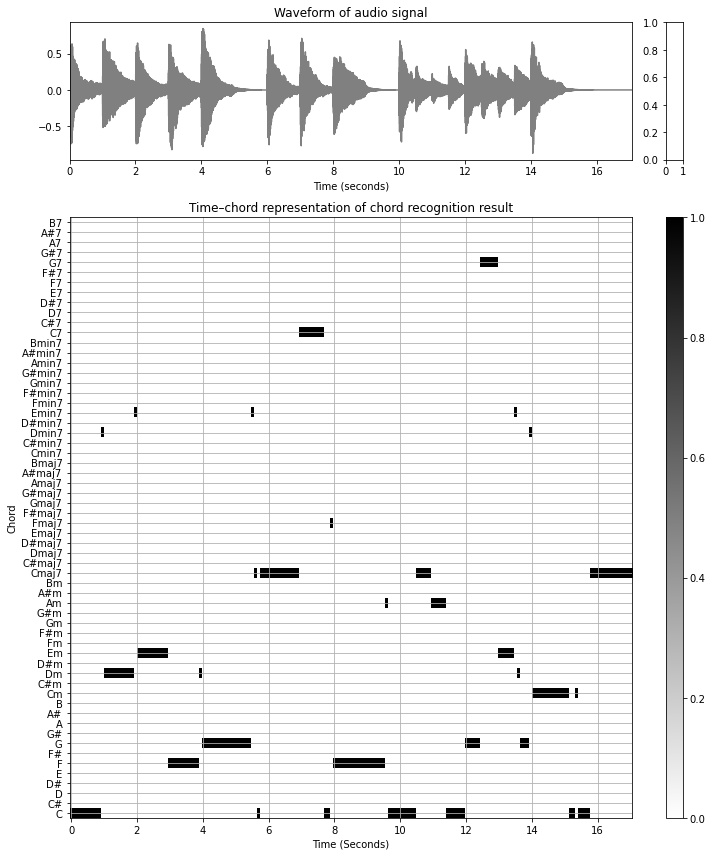

In [26]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('..')
import libfmp.b
import libfmp.c3
import libfmp.c4
# %matplotlib inline

def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Args:
        fn_wav (str): Filenname of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): Technique used for front-end decomposition ('STFT', 'IIS', 'CQT') (Default value = 'STFT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = libfmp.c3.normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

# Compute chroma features
fn_wav = os.path.join('data', 'audio', 'prova.wav')
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='IIR')

def get_chord_labels(ext_minor='m', ext_maj7='maj7', ext_min7='min7', ext_dominant='7', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels_maj7 = [s + ext_maj7 for s in chroma_labels]
    chord_labels_min7 = [s + ext_min7 for s in chroma_labels]
    chord_labels_dominant = [s + ext_dominant for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min+chord_labels_maj7+chord_labels_min7+chord_labels_dominant
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmaj7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]).T
    template_cmin7 = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]).T
    template_cdominant = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]).T
    num_chord = 60
    if nonchord:
        num_chord = 61
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
        chord_templates[:, shift+24] = np.roll(template_cmaj7, shift)
        chord_templates[:, shift+36] = np.roll(template_cmin7, shift)
        chord_templates[:, shift+48] = np.roll(template_cdominant, shift)
    #print(chord_templates)  
    return chord_templates

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

# Chord recognition
X = X_STFT
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max', nonchord=False)
chord_labels = get_chord_labels(nonchord=False)

#Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [0.8, 3.5]}, figsize=(10, 12))
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')
libfmp.b.plot_matrix(chord_max, ax=[ax[1,0], ax[1,1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='Time (Seconds)')
ax[1,0].set_yticks(np.arange( len(chord_labels) ))
ax[1,0].set_yticklabels(chord_labels)
ax[1,0].grid()
fig.tight_layout()

#Saving figure to path
#fig.savefig('C:\\Users\\DAVID\\Desktop\\Università\\plot.png') 

# Results as string and timestamps
def compute_results(chord_max, Fs, chord_labels):
    first_element = np.argmax(chord_max[:,0])
    chord_index = np.array([first_element])
    timestamps = np.array([0])
    shape1=chord_max.shape[1]
    for n in range(1, shape1):
        i = np.argmax(chord_max[:,n])
        j = np.argmax(chord_max[:,(n-1)])
        if i !=j:
            chord_index = np.append(chord_index, i)
            timestamps = np.append(timestamps, round(n/Fs, 2))
    a = []
    for n in range(chord_index.shape[0]):
        element = chord_index[n]
        a.append(chord_labels[element])
    results = np.array(a)
    return results, timestamps

results, timestamp = compute_results(chord_max, Fs_X, chord_labels)

print(results)
print(timestamp)